In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.utils.plot_utils import *
from csbdeep.data.transform import Transform

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.models import Config2D, StarDist2D, StarDistData2D
from stardist.models.sample_patches import sample_patches

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

np.random.seed(42)
lbl_cmap = random_label_cmap()

%reload_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Play with transformation (flip) using csbdeep's built-in 
But apparently the create_patches method in csbdeep is not creating them on-the-fly during the training thus become memory intensive. And it seems that the transformation that generates more image pairs does not fit into subsequent functions... and no built-in randomization parameters to use

[[ 7  6  6 ...  5  5  5]
 [ 7  7  6 ...  7  5  5]
 [ 5  7  6 ...  6  6  6]
 ...
 [ 6  6  7 ... 13 11 11]
 [ 7  6  7 ... 10  9  8]
 [ 6  6  7 ...  8  8  8]]


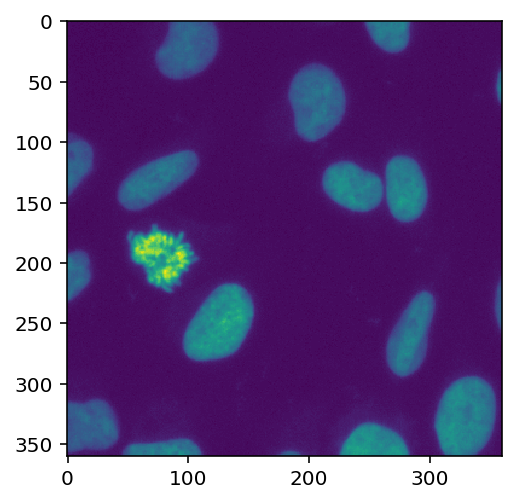

In [2]:
from csbdeep.data import RawData

raw_data = RawData.from_folder (
    basepath    = '/home/qzt/data/dsb2018/train_sub2',
    source_dirs = ['images'],
    target_dir  = 'masks',
    axes        = 'ZCYX',
)

image_pairs = raw_data.generator()

for x,y,axes,m_in in image_pairs:
    print(x)
#     print(y)
#     print(axes)
#     print(m_in)
    plt.imshow(np.squeeze(x[...,::-1]))
    

In [52]:
# flipx = Transform.flip(0)
# flipy = Transform.flip(1)
# from csbdeep.data import RawData, create_patches

# raw_data = RawData.from_folder (
#     basepath    = '/home/qzt/data/dsb2018/train_sub2',
#     source_dirs = ['images'],
#     target_dir  = 'masks',
#     axes        = 'ZCYX',
# )

# X, Y, XY_axes = create_patches (
#     raw_data            = raw_data,
#     patch_size          = (256,256),
#     n_patches_per_image = 4,
#     transforms          = [flipx],
# )


    1 raw images x    1 transformations   =     1 images
    1 images     x    4 patches per image =     4 patches in total
Input data:
/home/qzt/data/dsb2018/train_sub2: target='masks', sources=['images'], axes='ZCYX', pattern='*.tif*'
Transformations:
1 x Flip (axis=0)
1 x Identity
Patch size:
256 x 256



100%|██████████| 1/1 [00:00<00:00, 63.93it/s]


In [53]:
# assert X.shape == Y.shape
# print("shape of X,Y =", X.shape)
# print("axes  of X,Y =", XY_axes)

shape of X,Y = (4, 1, 256, 256)
axes  of X,Y = SCYX


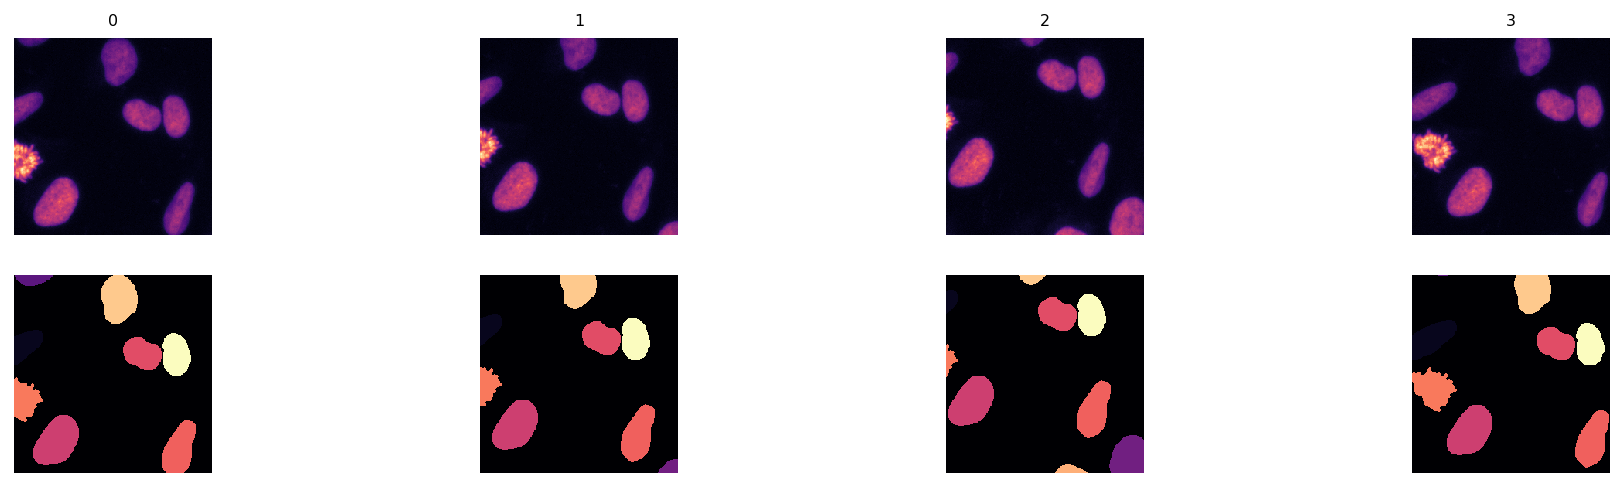

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 1152x288 with 0 Axes>

In [54]:
from csbdeep.utils import plot_some

for i in range(2):
    plt.figure(figsize=(16,4))
    sl = slice(8*i, 8*(i+1))
    plot_some(np.moveaxis(X[sl],1,-1),np.moveaxis(Y[sl],1,-1),title_list=[np.arange(sl.start,sl.stop)])
    plt.show()
None;


## Load sample data

In [12]:
# !pip install albumentations

In [2]:
X = sorted(glob('/home/qzt/data/dsb2018/train_sub/images/*.tif'))
Y = sorted(glob('/home/qzt/data/dsb2018/train_sub/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 5/5 [00:00<00:00, 309.13it/s]


In [3]:
# assert len(X) > 1, "not enough training data"
# rng = np.random.RandomState(42)
# ind = rng.permutation(len(X))
# n_val = max(1, int(round(0.15 * len(ind))))
# ind_train, ind_val = ind[:-n_val], ind[-n_val:]

#manual assign train/val index for debugging
ind_train = [1,2,3,4]
ind_val = [0]

X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:   5
- training:         4
- validation:       1


In [15]:
# i = 0
# img, lbl = X[i], Y[i]
# img, lbl = X_val[0], Y_val[0]
# assert img.ndim in (2,3)
# img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
# plt.figure(figsize=(16,10))
# plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
# plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
# None;

## Try with other augmentation packages and use stardist generator pipe (keras sequence) 

In [6]:
# import cv2
from albumentations import *

In [7]:
AUGMENTATIONS_TRAIN = Compose([
    Flip(p=0.5),
#     Rotate(p=1, interpolation=0),
#     RandomScale(scale_limit=0.5, interpolation=1, always_apply=True, p=0.9),
    Downscale(scale_min = 0.5, scale_max=0.5, p=0.5),
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0.5, rotate_limit=90, interpolation=0, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5)
])

In [8]:
data_train = StarDistData2D(X_trn, Y_trn, batch_size=1, n_rays=32, patch_size=(256,256), augmenter=AUGMENTATIONS_TRAIN, shape_completion=False)

In [9]:
type(data_train[0])

IndexError: tuple index out of range

In [19]:
XX, YY = data_train[0]

X,dist_mask = XX
prob,dist = YY

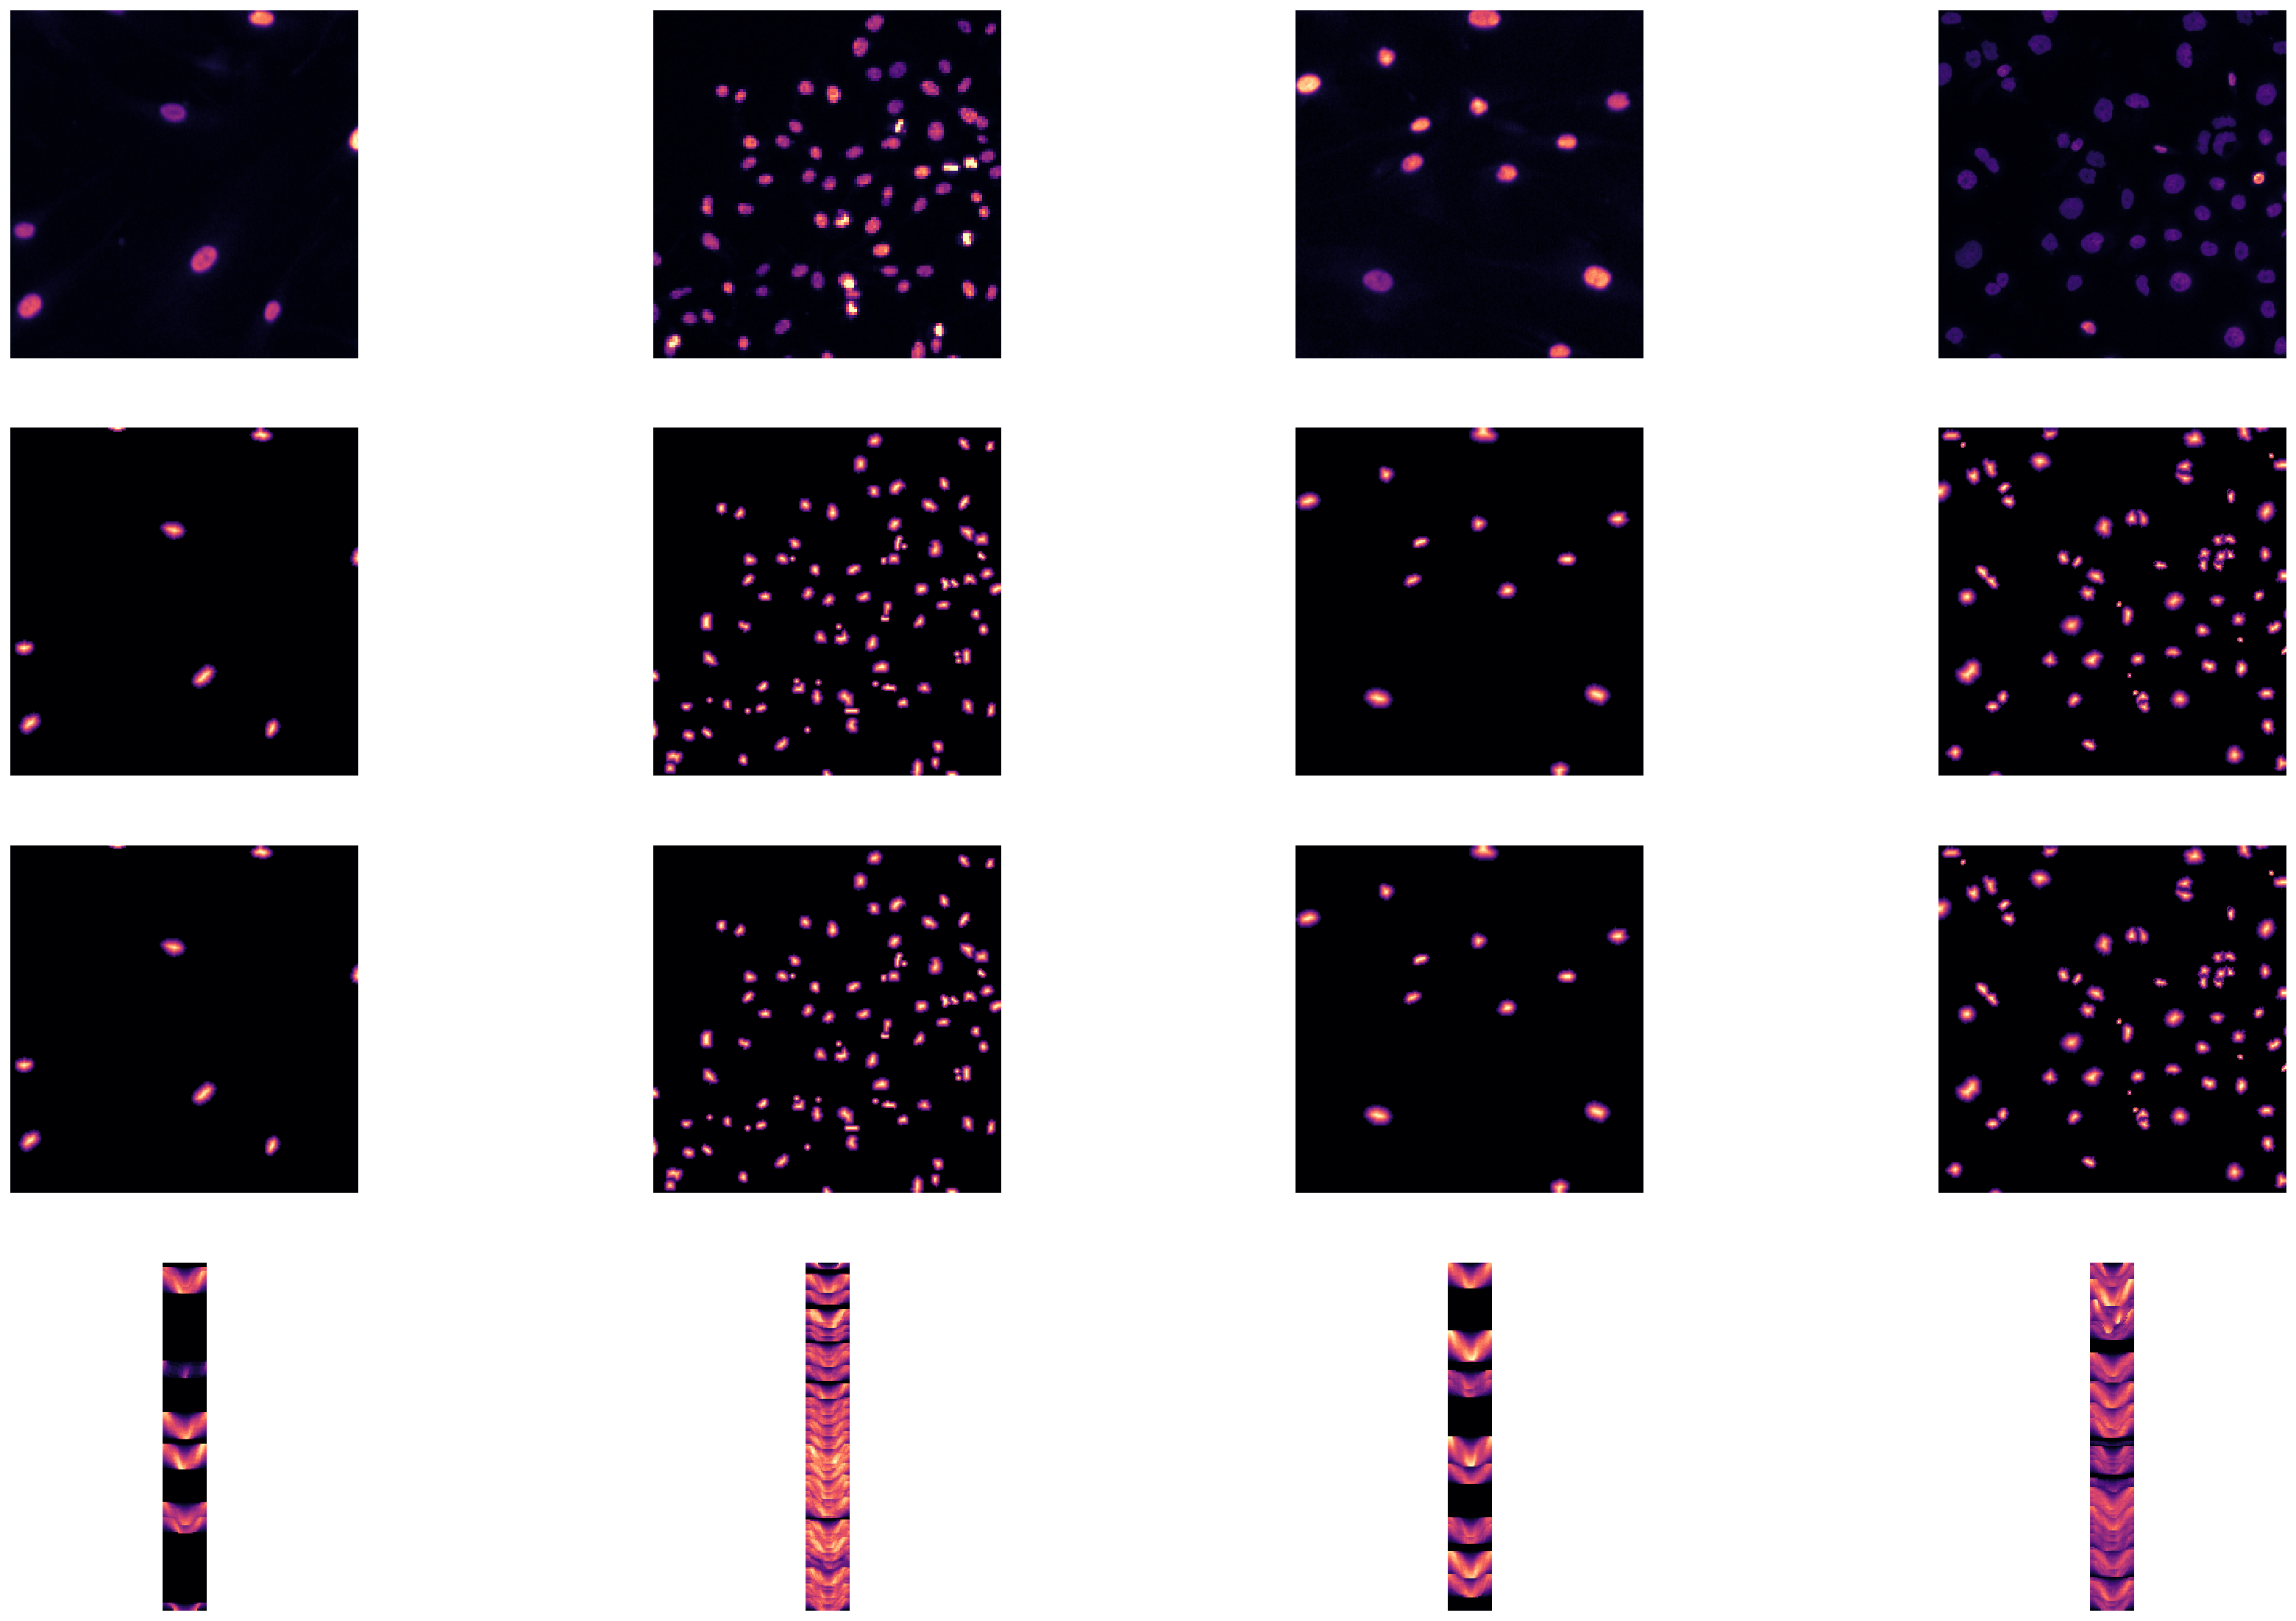

In [26]:
plot_some(X, dist_mask, prob, dist, x_inch=30, y_inch=20)

## Debug validation data part

In [27]:
validation_data=(X_val,Y_val)
data_kwargs = {'n_rays': 32, 'patch_size': (256, 256), 'grid': (2, 2), 'shape_completion': False, 'b': 32, 'use_gpu': False, 'foreground_prob': 0.9}
data_val = StarDistData2D(*validation_data, batch_size=1, **data_kwargs)

## Dig into the model

In [4]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
    train_batch_size = 1,  #no gpu
    train_epochs = 5,
    train_steps_per_epoch = 4,
    net_input_shape = (X_trn[0].shape[0], X_trn[0].shape[1], n_channel)
)

conf

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(256, 256, 1), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=1, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=5, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_shape_completion=False, train_steps_per_epoch=4, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', use_gpu=False)

In [5]:

model = StarDist2D(conf, name='stardist_exp', basedir='exp0')

/home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/csbdeep/models/base_model.py:134: UserWarning: output path for model already exists, files may be overwritten: /home/qzt/stardist/examples/2D/exp0/stardist_exp
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [6]:
model.keras_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 320         input[0][0]                      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

## load pretrained model

In [7]:
%pwd

'/home/qzt/stardist/examples/2D'

In [18]:
# load weights into current model in h5 format (keras)
model.keras_model.load_weights("models_test2/stardist/weights_last.h5")
print("Loaded model from disk")

Loaded model from disk


In [86]:
# builder = tf.saved_model.builder.SavedModelBuilder('dsb2018_heavy_augment')
loaded_model = tf.keras.models.load_model('./dsb2018_heavy_augment')

OSError: Unable to open file (file read failed: time = Thu Mar  5 17:32:54 2020
, filename = './dsb2018_heavy_augment', file descriptor = 43, errno = 21, error message = 'Is a directory', buf = 0x7ffd4afa92c0, total read size = 8, bytes this sub-read = 8, bytes actually read = 18446744073709551615, offset = 0)

In [62]:
# load weights in to new model (TF export)
imported = tf.saved_model.load_v2(export_dir='dsb2018_heavy_augment/', tags=None)
# tf.__version__
f = imported.signatures["serving_default"]

In [74]:
dir(model.keras_model)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_inbound_node',
 '_base_init',
 '_built',
 '_check_trainable_weights_consistency',
 '_collected_trainable_weights',
 '_compute_previous_mask',
 '_expects_training_arg',
 '_feed_input_names',
 '_feed_input_shapes',
 '_feed_inputs',
 '_feed_loss_fns',
 '_feed_output_names',
 '_feed_output_shapes',
 '_feed_outputs',
 '_feed_sample_weight_modes',
 '_feed_sample_weights',
 '_feed_targets',
 '_function_kwargs',
 '_get_callback_model',
 '_get_node_attribute_at_index',
 '_inbound_nodes',
 '_init_graph_network',
 '_init_subclassed_network',
 '_initial_weights',
 '_input_coordinat

In [70]:
with tf.Session(graph=tf.Graph()) as sess:
    tf.saved_model.loader.load(sess, ["serve"], 'dsb2018_heavy_augment')
    graph = tf.get_default_graph()
    print(graph.get_operations())
    
#     model = graph.get_tensor_by_name("finalnode:0")


[<tf.Operation 'input' type=Placeholder>, <tf.Operation 'dist_mask' type=Placeholder>, <tf.Operation 'conv2d_1/random_uniform/shape' type=Const>, <tf.Operation 'conv2d_1/random_uniform/min' type=Const>, <tf.Operation 'conv2d_1/random_uniform/max' type=Const>, <tf.Operation 'conv2d_1/random_uniform/RandomUniform' type=RandomUniform>, <tf.Operation 'conv2d_1/random_uniform/sub' type=Sub>, <tf.Operation 'conv2d_1/random_uniform/mul' type=Mul>, <tf.Operation 'conv2d_1/random_uniform' type=Add>, <tf.Operation 'conv2d_1/kernel' type=VariableV2>, <tf.Operation 'conv2d_1/kernel/Assign' type=Assign>, <tf.Operation 'conv2d_1/kernel/read' type=Identity>, <tf.Operation 'conv2d_1/Const' type=Const>, <tf.Operation 'conv2d_1/bias' type=VariableV2>, <tf.Operation 'conv2d_1/bias/Assign' type=Assign>, <tf.Operation 'conv2d_1/bias/read' type=Identity>, <tf.Operation 'conv2d_1/convolution/dilation_rate' type=Const>, <tf.Operation 'conv2d_1/convolution' type=Conv2D>, <tf.Operation 'conv2d_1/BiasAdd' type=B

In [77]:
with tf.Graph().as_default() as graph, tf.Session() as sess:
    tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], 'dsb2018_heavy_augment')
    graph_def = tf.GraphDef()
    graph_def = tf.get_default_graph().as_graph_def()
    g_in = tf.import_graph_def(graph_def)
    writer = tf.summary.FileWriter('log/')
    writer.add_graph(sess.graph)
    writer.flush()
    writer.close()

In [12]:
out = []

with tf.Graph().as_default() as graph, tf.Session() as sess:
    tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], 'dsb2018_heavy_augment')
    graph_def = tf.GraphDef()
    graph_def = tf.get_default_graph().as_graph_def()
    g_in = tf.import_graph_def(graph_def)
    graph_nodes=[n for n in graph_def.node]
#     wts = [n for n in graph_nodes if n.op=='Const']
    wts = [n for n in graph_nodes ]
    weight_dict = {}
    for i, n in enumerate(wts):
        weight_dict[n.name] = i
    out = weight_dict

In [13]:
weight_dict

{'input': 0,
 'dist_mask': 1,
 'conv2d_1/random_uniform/shape': 2,
 'conv2d_1/random_uniform/min': 3,
 'conv2d_1/random_uniform/max': 4,
 'conv2d_1/random_uniform/RandomUniform': 5,
 'conv2d_1/random_uniform/sub': 6,
 'conv2d_1/random_uniform/mul': 7,
 'conv2d_1/random_uniform': 8,
 'conv2d_1/kernel': 9,
 'conv2d_1/kernel/Assign': 10,
 'conv2d_1/kernel/read': 11,
 'conv2d_1/Const': 12,
 'conv2d_1/bias': 13,
 'conv2d_1/bias/Assign': 14,
 'conv2d_1/bias/read': 15,
 'conv2d_1/convolution/dilation_rate': 16,
 'conv2d_1/convolution': 17,
 'conv2d_1/BiasAdd': 18,
 'conv2d_1/Relu': 19,
 'conv2d_2/random_uniform/shape': 20,
 'conv2d_2/random_uniform/min': 21,
 'conv2d_2/random_uniform/max': 22,
 'conv2d_2/random_uniform/RandomUniform': 23,
 'conv2d_2/random_uniform/sub': 24,
 'conv2d_2/random_uniform/mul': 25,
 'conv2d_2/random_uniform': 26,
 'conv2d_2/kernel': 27,
 'conv2d_2/kernel/Assign': 28,
 'conv2d_2/kernel/read': 29,
 'conv2d_2/Const': 30,
 'conv2d_2/bias': 31,
 'conv2d_2/bias/Assign': 

In [17]:
wts[3]

name: "conv2d_1/random_uniform/min"
op: "Const"
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "value"
  value {
    tensor {
      dtype: DT_FLOAT
      tensor_shape {
      }
      float_val: -0.14213381707668304
    }
  }
}

In [10]:
wts[1].attr['value'].tensor

dtype: DT_INT32
tensor_shape {
  dim {
    size: 2
  }
}
tensor_content: "\001\000\000\000\001\000\000\000"

In [105]:
from tensorflow.python.framework import tensor_util
tensor_util.MakeNdarray(wts[3].attr['value'].tensor)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [104]:
wtensor = wts[3].attr['value'].tensor
weight = tensor_util.MakeNdarray(wtensor)
weights.append(weight)

NameError: name 'weights' is not defined

In [72]:
# Create graph before session :)

with tf.Graph().as_default() as graph, tf.Session() as sess:
    tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], 'dsb2018_heavy_augment')
    model = CustomModel()
    model.graph_def = tf.get_default_graph().as_graph_def()
    T = render.make_vis_T(model, "Mixed5b:1")

NameError: name 'CustomModel' is not defined

In [71]:
    with T("vis_op").graph.as_default():
              # initialize your model's variables
               tf.initialize_all_variables().run()
    # this may not be required as lucid will not execute default graph but only the graph it has created
#     tf.initialize_all_variables().run()
#     for i in range(10):
#       T("vis_op").run()
#       showarray(T("input").eval()[0])

['_ControlDependenciesController',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_control_dependencies',
 '_add_device_to_stack',
 '_add_function',
 '_add_new_tf_operations',
 '_add_op',
 '_apply_device_functions',
 '_as_graph_def',
 '_as_graph_element_locked',
 '_attr_scope',
 '_attr_scope_map',
 '_auto_cast_variable_read_dtype',
 '_building_function',
 '_c_graph',
 '_check_not_finalized',
 '_collections',
 '_colocate_with_for_gradient',
 '_colocation_stack',
 '_container',
 '_control_dependencies_for_inputs',
 '_control_dependencies_stack',
 '_control_flow_context',
 '_copy_functions_to_graph_def',
 '_create_op_from_tf_operation',
 '_create_op_helper',
 '_curr

In [44]:
f.output

['__abstractmethods__',
 '__add__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__delslice__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getslice__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__setslice__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_add_variable_with_custom_getter',
 '_check_external_modification',
 '_checkpoint_dependencies',
 '_deferred_dependencies',
 '_external_modification',
 '_gather_saveables_for_checkpoint',
 '_handle_deferred_dependencies',
 '_last_wrapped_list_snapshot',
 '_layers',
 '_list_functions_for_serialization',
 '_looku

In [52]:
imported.variables[0]

IndexError: list index out of range

In [18]:
#check the trainable status in each layer
for l in model.keras_model.layers:
    print(l, l.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f0aca279bd0> False
<keras.layers.convolutional.Conv2D object at 0x7f0aca2c7950> True
<keras.layers.convolutional.Conv2D object at 0x7f0aca2c7650> True
<keras.layers.pooling.MaxPooling2D object at 0x7f0aca279250> True
<keras.layers.convolutional.Conv2D object at 0x7f0aca5ab690> True
<keras.layers.convolutional.Conv2D object at 0x7f0aca5abb50> True
<keras.layers.pooling.MaxPooling2D object at 0x7f0aca5ab950> True
<keras.layers.convolutional.Conv2D object at 0x7f0aca552b50> True
<keras.layers.convolutional.Conv2D object at 0x7f0aca571690> True
<keras.layers.pooling.MaxPooling2D object at 0x7f0aca5ab610> True
<keras.layers.convolutional.Conv2D object at 0x7f0aca4bff10> True
<keras.layers.convolutional.Conv2D object at 0x7f0aca4bf910> True
<keras.layers.pooling.MaxPooling2D object at 0x7f0aca53fd90> True
<keras.layers.convolutional.Conv2D object at 0x7f0aca480510> True
<keras.layers.convolutional.Conv2D object at 0x7f0aca49aad0> True
<keras.

In [19]:
# freeze all the layers except the last 3 --> only keep feature layer, prob, dist trainable
for l in model.keras_model.layers[:-3]:
    l.trainable = False

for l in model.keras_model.layers:
    print(l, l.trainable)


<keras.engine.input_layer.InputLayer object at 0x7f0aca279bd0> False
<keras.layers.convolutional.Conv2D object at 0x7f0aca2c7950> False
<keras.layers.convolutional.Conv2D object at 0x7f0aca2c7650> False
<keras.layers.pooling.MaxPooling2D object at 0x7f0aca279250> False
<keras.layers.convolutional.Conv2D object at 0x7f0aca5ab690> False
<keras.layers.convolutional.Conv2D object at 0x7f0aca5abb50> False
<keras.layers.pooling.MaxPooling2D object at 0x7f0aca5ab950> False
<keras.layers.convolutional.Conv2D object at 0x7f0aca552b50> False
<keras.layers.convolutional.Conv2D object at 0x7f0aca571690> False
<keras.layers.pooling.MaxPooling2D object at 0x7f0aca5ab610> False
<keras.layers.convolutional.Conv2D object at 0x7f0aca4bff10> False
<keras.layers.convolutional.Conv2D object at 0x7f0aca4bf910> False
<keras.layers.pooling.MaxPooling2D object at 0x7f0aca53fd90> False
<keras.layers.convolutional.Conv2D object at 0x7f0aca480510> False
<keras.layers.convolutional.Conv2D object at 0x7f0aca49aad0>

In [22]:
# print(model.keras_model.summary())
from albumentations import *
AUGMENTATIONS_TRAIN = Compose([
    Flip(p=0.5),
#     Rotate(p=1, interpolation=0),
#     RandomScale(scale_limit=0.5, interpolation=1, always_apply=True, p=0.9),
    Downscale(scale_min = 0.5, scale_max=0.5, p=0.5),
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0.5, rotate_limit=90, interpolation=0, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5)
])

In [23]:
# %debug
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=AUGMENTATIONS_TRAIN)

Epoch 1/5
4/4 [==============================] - 1s 190ms/step - loss: 0.7433 - prob_loss: 0.2345 - dist_loss: 2.5440 - prob_kld: 0.1989 - dist_relevant_mae: 2.5436 - dist_relevant_mse: 11.4954 - val_loss: 0.6920 - val_prob_loss: 0.2876 - val_dist_loss: 2.0219 - val_prob_kld: 0.1885 - val_dist_relevant_mae: 2.0212 - val_dist_relevant_mse: 7.2249
Epoch 2/5
4/4 [==============================] - 0s 75ms/step - loss: 0.6510 - prob_loss: 0.1683 - dist_loss: 2.4134 - prob_kld: 0.1346 - dist_relevant_mae: 2.4130 - dist_relevant_mse: 10.3573 - val_loss: 1.0364 - val_prob_loss: 0.4804 - val_dist_loss: 2.7801 - val_prob_kld: 0.3813 - val_dist_relevant_mae: 2.7794 - val_dist_relevant_mse: 11.9837
Epoch 3/5
4/4 [==============================] - 0s 69ms/step - loss: 0.5945 - prob_loss: 0.1530 - dist_loss: 2.2079 - prob_kld: 0.1193 - dist_relevant_mae: 2.2075 - dist_relevant_mse: 9.0276 - val_loss: 1.2410 - val_prob_loss: 0.6263 - val_dist_loss: 3.0735 - val_prob_kld: 0.5272 - val_dist_relevant_ma

In [11]:
model.keras_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 320         input[0][0]                      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 3 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, None, None, 3 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

### play and experiment with the original code

In [11]:
i=0

idx = slice(i*data_train.batch_size,(i+1)*data_train.batch_size);idx

idx = list(data_train.perm[idx])
idx

[3, 2, 1, 0]

In [12]:
arrays = [sample_patches((data_train.Y[k],) + data_train.channels_as_tuple(data_train.X[k]),
             patch_size=data_train.patch_size, n_samples=1,
             valid_inds=data_train.get_valid_inds(k)) for k in idx]

len(arrays)

4

For each idx, sample_patches will extract patches from image and mask , the resulting "arrays" is actually a list of arrays(lenth of 2: mask, image).
As we pass 4 indexes , the length of this list is 4

In [13]:
len(arrays[0])

2

Here the Image(X) and Mask(Y) array was again extracted from the arrays list. Not in array type but as tuple...

In [ ]:
X, Y = list(zip(*[(x[0][data_train.b],y[0]) for y,x in arrays]))
X.shape  --> X is not an array

In [ ]:
# plt.imshow(np.squeeze(X))

In order to test the augmentation (using the albumatation package), images need to be passed as arrays, and then grouped in dict with key image and mask.

In [ ]:
Xa = np.asanyarray(X)
Ya = np.asanyarray(Y)
Xa.shape, Ya.shape

In [ ]:
data_train.augmenter = AUGMENTATIONS_TRAIN
xx, yy = zip(*[data_train.augmenter(**{"image":_x,"mask": _y}).values() for _x, _y in zip(Xa,Ya)])
type(xx)

In [ ]:
plot_some(xx,yy)

The original code when augmenter was set to None

In [ ]:
data_train.augmenter = lambda *args: args
Xb, Yb = tuple(zip(*tuple(data_train.augmenter(_x, _y) for _x, _y in zip(X,Y))))
type(Xb)

In [ ]:
Xb

### Try a more understandable style (at least by myself...)

In [10]:
i=0
idx = slice(i*data_train.batch_size,(i+1)*data_train.batch_size);idx # here the idx progresses in step of batch_size as the i progresses
idx = list(data_train.perm[idx])   


In [11]:
idx

[3]

In [12]:
# the output from the sample_patches is also a list..... so basically we turn a list of list into a n-dim array
arrays = np.hstack([sample_patches((data_train.Y[k],) + data_train.channels_as_tuple(data_train.X[k]),
             patch_size=data_train.patch_size, n_samples=1,
             valid_inds=data_train.get_valid_inds(k)) for k in idx])

In [14]:
type(arrays), arrays.shape

(numpy.ndarray, (2, 1, 256, 256))

In [16]:
X = arrays[1,...,data_train.bb,data_train.bb]  #the elipsis at second dimension is reserved for channels>1, but not really tested
Y = arrays[0,...,data_train.bb,data_train.bb].astype('uint16')
X.shape, Y.shape

((1, 256, 256), (1, 256, 256))

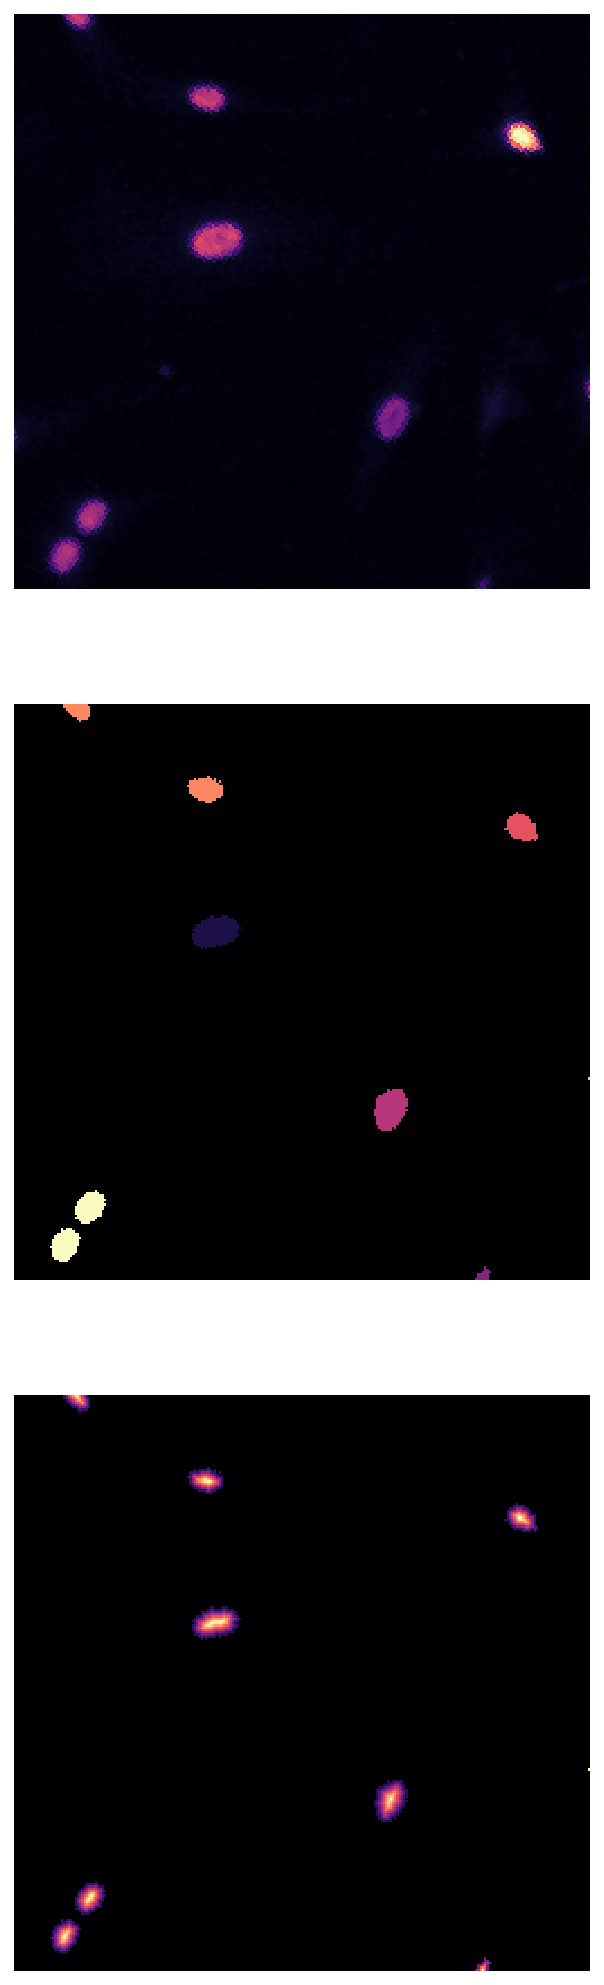

In [18]:
data_train.augmenter = AUGMENTATIONS_TRAIN
XX, YY = zip(*[data_train.augmenter(**{"image":_x,"mask": _y}).values() for _x, _y in zip(X,Y)]) ## output XX, YY are tuples so we can plug them back into the pipe
from stardist.utils import (edt_prob, _normalize_grid) 

prob = np.stack([edt_prob(lbl[data_train.b]) for lbl in YY])
plot_some(XX, YY, prob, x_inch=25, y_inch=18)

In [19]:
from stardist.geometry import star_dist
if data_train.shape_completion:
    Y_cleared = [clear_border(lbl) for lbl in YY]
    dist      = np.stack([star_dist(lbl,data_train.n_rays,mode=data_train.sd_mode)[data_train.b+(slice(None),)] for lbl in Y_cleared])
    dist_mask = np.stack([edt_prob(lbl[data_train.b]) for lbl in Y_cleared])
else:
    dist      = np.stack([star_dist(lbl,data_train.n_rays,mode=data_train.sd_mode) for lbl in YY])
    dist_mask = prob

XX = np.stack(XX)
if XX.ndim == 3: # input image has no channel axis
    XX = np.expand_dims(XX,-1)
    prob = np.expand_dims(prob,-1)
    dist_mask = np.expand_dims(dist_mask,-1)

# subsample wth given grid
dist_mask = dist_mask[data_train.ss_grid]
prob      = prob[data_train.ss_grid]
dist      = dist[data_train.ss_grid]

# return [X,dist_mask], [prob,dist]

In [20]:
dist_mask.shape

(1, 256, 256, 1)

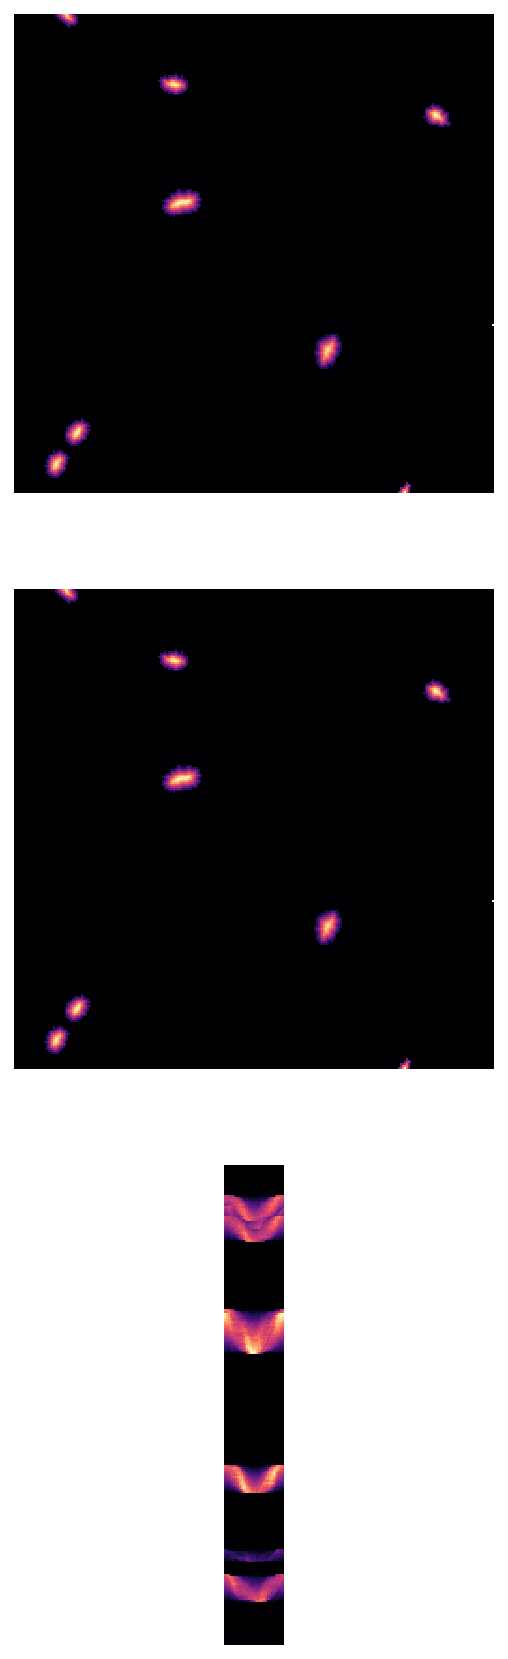

In [21]:
plot_some(dist_mask, prob, dist)

In [22]:
dist.shape  #dist is the star radius of the 32 (n_rays) at each pixel value. 

(1, 256, 256, 32)

In [ ]:
data_train = StarDistData2D(X_trn, Y_trn, batch_size=4, n_rays=32, patch_size=(256,256), augmenter=None, shape_completion=False)

In [189]:
# %debug
# data_train[0]

> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/model2d.py(60)<genexpr>()
     58         else:
     59             X, Y = list(zip(*[(np.stack([_x[0] for _x in x],axis=-1)[self.b], y[0]) for y,*x in arrays]))
---> 60 
     61         X, Y = tuple(zip(*tuple(self.augmenter(_x, _y) for _x, _y in zip(X,Y))))
     62 



ipdb>  c


> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/model2d.py(82)__getitem__()
     80 
     81         # subsample wth given grid
---> 82         dist_mask = dist_mask[self.ss_grid]
     83         prob      = prob[self.ss_grid]
     84         dist      = dist[self.ss_grid]



ipdb>  dist_mask.shape


(4, 256, 256, 1)


ipdb>  help



Documented commands (type help <topic>):
EOF    cl         disable  interact  next    psource  rv         unt   
a      clear      display  j         p       q        s          until 
alias  commands   down     jump      pdef    quit     source     up    
args   condition  enable   l         pdoc    r        step       w     
b      cont       exit     list      pfile   restart  tbreak     whatis
break  continue   h        ll        pinfo   return   u          where 
bt     d          help     longlist  pinfo2  retval   unalias  
c      debug      ignore   n         pp      run      undisplay

Miscellaneous help topics:
exec  pdb



ipdb>  EOF


BdbQuit: 

## test code to understand tuple and list comprehension

In [3]:
i = np.arange(10)
j = ['a','b','c','d','e','f','g','h','i','j']

In [4]:
dict = {"num":i, "alphbet":j}

In [6]:
def noop(**kwargs):
    return kwargs

noop(**dict)

{'num': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'alphbet': ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']}

dict.values() is used intead of items() so that the output is directly arrays of values instead of arrays of dict (which need to retrieved again..)

In [37]:
out = [{"num":_i, "alphbet":_j}.values() for _i, _j in zip(i,j)]
out

[dict_values([0, 'a']),
 dict_values([1, 'b']),
 dict_values([2, 'c']),
 dict_values([3, 'd']),
 dict_values([4, 'e']),
 dict_values([5, 'f']),
 dict_values([6, 'g']),
 dict_values([7, 'h']),
 dict_values([8, 'i']),
 dict_values([9, 'j'])]

In [38]:
out1 = [{"num":_i, "alphbet":_j} for _i, _j in zip(i,j)]
out1

[{'num': 0, 'alphbet': 'a'},
 {'num': 1, 'alphbet': 'b'},
 {'num': 2, 'alphbet': 'c'},
 {'num': 3, 'alphbet': 'd'},
 {'num': 4, 'alphbet': 'e'},
 {'num': 5, 'alphbet': 'f'},
 {'num': 6, 'alphbet': 'g'},
 {'num': 7, 'alphbet': 'h'},
 {'num': 8, 'alphbet': 'i'},
 {'num': 9, 'alphbet': 'j'}]

In [39]:
out2 = ({"num":_i, "alphbet":_j}.items() for _i, _j in zip(i,j))

out2

<generator object <genexpr> at 0x7f039a992cd0>

In [40]:
out3 = tuple({"num":_i, "alphbet":_j}.items() for _i, _j in zip(i,j))
out3

(dict_items([('num', 0), ('alphbet', 'a')]),
 dict_items([('num', 1), ('alphbet', 'b')]),
 dict_items([('num', 2), ('alphbet', 'c')]),
 dict_items([('num', 3), ('alphbet', 'd')]),
 dict_items([('num', 4), ('alphbet', 'e')]),
 dict_items([('num', 5), ('alphbet', 'f')]),
 dict_items([('num', 6), ('alphbet', 'g')]),
 dict_items([('num', 7), ('alphbet', 'h')]),
 dict_items([('num', 8), ('alphbet', 'i')]),
 dict_items([('num', 9), ('alphbet', 'j')]))

use of [] list comprehension or tuple()  to enclose the for loop has no difference as we pass the output by * unpacking to the zip so that each element (columns in contrast to row) can be retrieved by the a,b at LHS. If the zip(\*XXX) trick is not used, a , b will be each row of the list not column

In [41]:
a, b = zip(*out)
a,b

((0, 1, 2, 3, 4, 5, 6, 7, 8, 9),
 ('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'))

In [42]:
a, b = zip(*out3)
a,b

((('num', 0),
  ('num', 1),
  ('num', 2),
  ('num', 3),
  ('num', 4),
  ('num', 5),
  ('num', 6),
  ('num', 7),
  ('num', 8),
  ('num', 9)),
 (('alphbet', 'a'),
  ('alphbet', 'b'),
  ('alphbet', 'c'),
  ('alphbet', 'd'),
  ('alphbet', 'e'),
  ('alphbet', 'f'),
  ('alphbet', 'g'),
  ('alphbet', 'h'),
  ('alphbet', 'i'),
  ('alphbet', 'j')))

In [46]:
c = list(zip(*out3))
type(c), len(c)

(list, 2)

In [48]:
c[0]

tuple

In [92]:
for _x, _y in zip(Xa,Ya):
    res = data_train.augmenter(**{"image":_x,"mask": _y}) 
X = res['image']
Y = res['mask']

TypeError: list indices must be integers or slices, not str

In [89]:
X

({'image': array([[ 0.00411523,  0.00823045,  0.00411523, ...,  0.00411523,
           0.00823045,  0.00823045],
         [ 0.00411523,  0.00411523,  0.00823045, ...,  0.00823045,
           0.        ,  0.01234568],
         [ 0.        ,  0.00823045,  0.        , ...,  0.00823045,
           0.00411523,  0.        ],
         ...,
         [ 0.        ,  0.00411523,  0.00411523, ...,  0.00823045,
           0.01234568,  0.00823045],
         [ 0.        ,  0.        ,  0.00411523, ...,  0.00823045,
           0.00411523,  0.00411523],
         [-0.00411523,  0.00411523,  0.        , ...,  0.00411523,
           0.00411523,  0.00823045]], dtype=float32),
  'mask': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)},)

In [51]:
xx, yy = data_train.__getitem__(0)

plot_some(xx)

TypeError: __call__() takes from 1 to 2 positional arguments but 3 were given

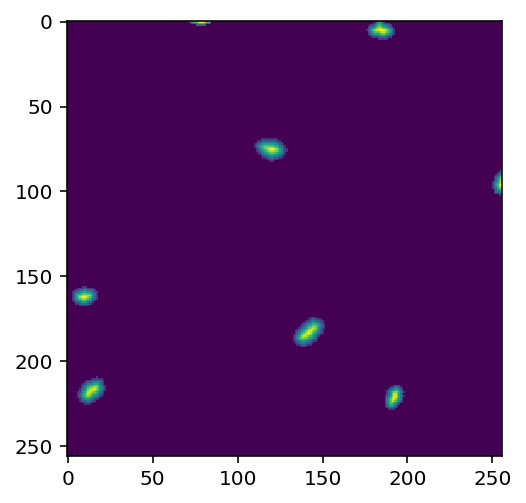

In [24]:
plt.imshow(np.squeeze(xx[1]))

Normalize images and fill small label holes.

Split into train and validation datasets.

Training data consists of pairs of input image and label instances.

# Configuration

A `StarDist2D` model is specified via a `Config2D` object.

In [ ]:
print(Config2D.__doc__)

In [ ]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
    train_batch_size = 1,  #no gpu
    train_epochs = 400,
    train_steps_per_epoch = 100
)
print(conf)
vars(conf)

In [ ]:
# if use_gpu:
#     from csbdeep.utils.tf import limit_gpu_memory
#     # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
#     limit_gpu_memory(0.8)

**Note:** The trained `StarDist2D` model will *not* predict completed shapes for partially visible objects at the image boundary if `train_shape_completion=False` (which is the default option).

In [ ]:
%pwd

In [ ]:
model = StarDist2D(conf, name='stardist', basedir='models_test2')

Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [ ]:
#skipped temporarily
# median_size = calculate_extents(list(Y), np.median)
# fov = np.array(model._axes_tile_overlap('YX'))
# if any(median_size > fov):
#     print("WARNING: median object size larger than field of view of the neural network.")

# Training

You can define a function/callable that applies augmentation to each batch of the data generator.

In [ ]:
augmenter = None

# def augmenter(x, y):
#     """Augmentation of a single input/label image pair.
#     x is an input image
#     y is the corresponding ground-truth label image
#     """
#     # modify a copy of x and/or y...
#     return x, y

We recommend to monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard). You can start it in the shell from the current working directory like this:

    $ tensorboard --logdir=.

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.


In [ ]:
%cd /home/qzt/stardist/examples/2D

In [ ]:
quick_demo = False

if quick_demo:
    print (
        "NOTE: This is only for a quick demonstration!\n"
        "      Please set the variable 'quick_demo = False' for proper (long) training.",
        file=sys.stderr, flush=True
    )
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                epochs=2, steps_per_epoch=10)

    print("====> Stopping training and loading previously trained demo model from disk.", file=sys.stderr, flush=True)
    model = StarDist2D(None, name='2D_demo', basedir='../../models/examples')
    model.basedir = None # to prevent files of the demo model to be overwritten (not needed for your model)
else:
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)
None;

# Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [ ]:
model.optimize_thresholds(X_val, Y_val)

In [ ]:
%pwd

In [ ]:
model.export_TF(fname='test')

In [ ]:
# export_TF(self, fname=None, single_output=True, upsample_grid=True)
# tf.saved_model.save(model, "/home/qzt/data/")